# yolo-v1

## 背景

实时的重要性

从网络设计上，YOLO与rcnn、fast rcnn及faster rcnn的区别如下：  
**[1] 训练模式**     
**YOLO：单阶段检测器,是端到端训练。**   
训练和检测均是在一个单独网络中进行。YOLO没有显示地求取region proposal的过程。  
**RCNN/Fast RCNN：双阶段检测器，SS + 检测(proposal+classifier)。**   
**Faster：双阶段检测器，SS(网络模型提取)+检测(proposal-net+classifier)。**  
**rcnn/fast rcnn：** 采用分离的模块（独立于网络之外的selective search方法）求取候选框（可能会包含物体的矩形区域），训练过程因此也是分成多个模块进行。Faster rcnn使用RPN（region proposal network）卷积网络替代rcnn/fast rcnn的selective search模块，将RPN集成到fast rcnn检测网络中，得到一个统一的检测网络。尽管RPN与fast rcnn共享卷积层，但是在模型训练过程中，需要反复训练RPN网络和fast rcnn网络（注意这两个网络核心卷积层是参数共享的）。  
**[2] 问题转化。**  
YOLO将物体检测作为一个**回归问题进行求解**，输入图像经过一次inference，便能得到图像中所有物体的位置和其所属类别及相应的置信概率。而rcnn/fast rcnn/faster rcnn将检测结果分为两部分求解：物体类别（分类问题），物体位置即bounding box（回归问题）。

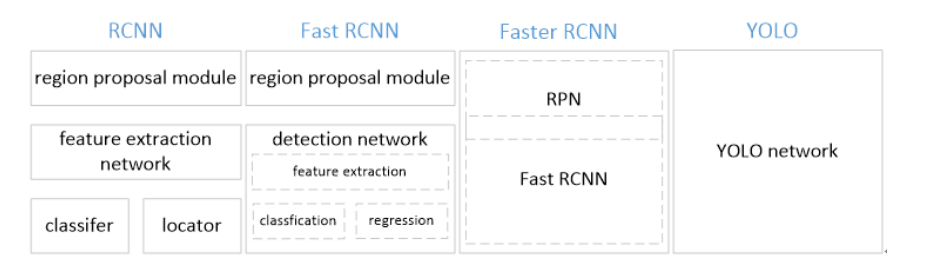

## 创新

**&radic;&nbsp;**  YOLO将物体检测转化为回归问题求解。  
**&radic;&nbsp;**  YOLO创造性的将候选区和对象识别这两个阶段合二为一。基于一个单独的end-to-end网络，完成从原始图像的输入到物体位置和类别的输出。  
> 实际上，YOLO并没有真正去掉候选区，而是采用了预定义的候选区（准确说应该是预测区，并不是Faster RCNN所采用的Anchor）。也就是将图片划分为 7*7=49 个网格（grid），每个网格允许预测出2个边框（bounding box，包含某个对象的矩形框），总共 49*2=98 个bounding box。可以理解为98个候选区，它们很粗略的覆盖了图片的整个区域。  
>>  
✌️RCNN：我们先来研究一下图片，嗯，这些位置很可能存在一些对象，你们对这些位置再检测一下看到底是哪些对象在里面。  
✌️YOLO：我们把图片大致分成98个区域，每个区域看下有没有对象存在，以及具体位置在哪里。  
✌️RCNN：你这么简单粗暴真的没问题吗？  
✌️YOLO：当然没有......咳，其实是有一点点问题的，准确率要低一点，但是我非常快！快！快！  
✌️RCNN：为什么你用那么粗略的候选区，最后也能得到还不错的bounding box呢？  
✌️YOLO：你不是用过边框回归吗？我拿来用用怎么不行了。  

## 核心思想
将一幅图像分成SxS个网格(grid cell)，如果某个object的中心落在这个网格中，则这个网格就负责预测这个object。  
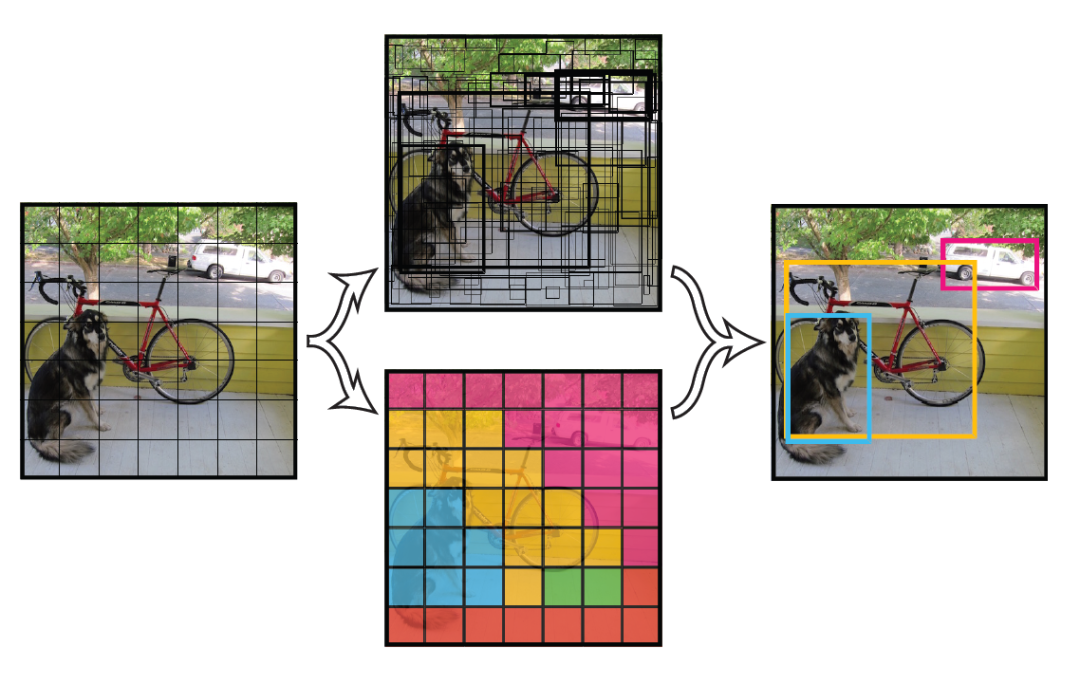  
每个网格要预测B个bounding box，每个bounding box除了要回归自身的位置之外，还要附带预测一个confidence值。  
这个confidence代表了所预测的box中含有object的置信度和这个box预测的有多准两种信息，其值是这样计算的：


### 流程
1> YOLO将对象检测重新定义为一个回归问题。它将单个卷积神经网络(CNN)应用于整个图像，将图像分成网格，并预测每个网格的类概率和边界框。例如，以一个448x448的图像为例。我们把它分成网格，比如7x7。YOLO的结构非常简单，就是单纯的卷积、池化最后加了两层全连接。最大的差异是最后输出层用线性函数做激活函数，因为需要预测bounding box的位置（数值型），而不仅仅是对象的概率。YOLO网络结构由24个卷积层与2个全连接层构成，网络入口为448x448(v2为416x416)，图片进入网络先经过resize，网络的输出结果为一个张量，维度为：  
  
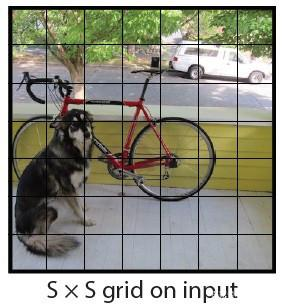  
其中，S为划分网格数，B为每个网格负责的边框个数，C为类别个数。每个小格会对应B个边界框，边界框的宽高范围为全图，表示以该小格为中心寻找物体的边界框位置。每个边界框对应一个分值，代表该处是否有物体及定位准确度：  
  
每个小格会对应C个概率值，找出最大概率对应的类别P(Class|object)，并认为小格中包含该物体或者该物体的一部分。  

2> 对于每个网格，网络都会预测一个边界框和与每个类别（汽车，行人，交通信号灯等）相对应的概率。  
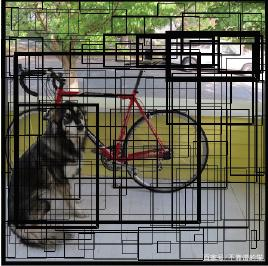  
每个边界框可以使用四个描述符进行描述：  
> + 边界框的中心  
> + 高度  
> + 宽度  
> + 值映射到对象所属的类  
> + 该算法还可以预测边界框中存在对象的概率。如果一个对象的中心落在一个网格单元中，则该网格单元负责检测该对象。每个网格中将有多个边界框。在训练时，我们希望每个对象只有一个边界框。因此，我们根据哪个Box与ground truth box的重叠度最高，从而分配一个Box来负责预测对象。  

3> 我们对每个类的对象应用一个称为“非最大抑制（Non Max Suppression）”的方法来过滤出“置信度”小于阈值的边界框。这为我们提供了图像预测。 
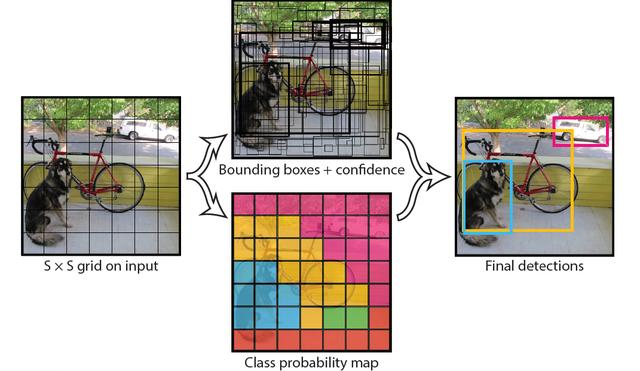  

输入/输出关系：
输入： 输入就是原始图像，唯一的要求是缩放到448*448的大小。主要是因为YOLO的网络中，卷积层最后接了两个全连接层，全连接层是要求固定大小的向量作为输入，所以倒推回去也就要求原始图像有固定的尺寸。那么YOLO设计的尺寸就是448*448。  
输出：输出是一个 7*7*30 的张量（tensor）。  
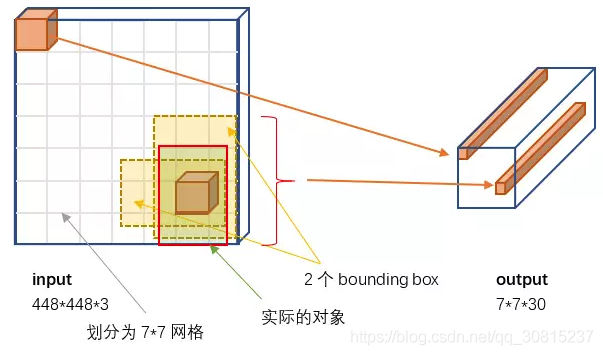  
输入图像被划分为 7*7 的网格（grid），输出张量中的 7*7 就对应着输入图像的 7*7 网格。或者我们把 7*7*30 的张量看作49个30维的向量，也就是输入图像中的每个网格对应输出一个30维的向量。参考上图，比如输入图像左上角的网格对应到输出张量中左上角的向量。  
要注意的是，并不是说仅仅网格内的信息被映射到一个30维向量。经过神经网络对输入图像信息的提取和变换，网格周边的信息也会被识别和整理，最后编码到那个30维向量中。具体来看每个网格对应的30维向量中包含了哪些信息？  
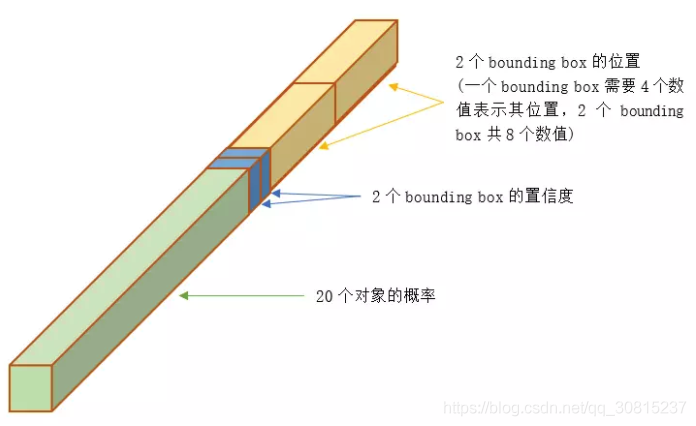  
① 20个对象分类的概率  
    YOLO支持识别20种不同的对象（人、鸟、猫、汽车、椅子等），所以这里有20个值表示该网格位置存在任一种对象的概率。可以记为 P(C_1|Object), ......, P(C_i|Object),......P(C_{20}|Object)，之所以写成条件概率，意思是如果该网格存在一个对象Object，那么它是C_i的概率是P(C_i|Object)。  
② 2个bounding box的位置  
    每个bounding box需要4个数值来表示其位置，(Center_x,Center_y,width,height)，即(bounding box的中心点的x坐标，y坐标，宽度，高度)，2个bounding box共需要8个数值来表示其位置。其中坐标的 x, y 用对应网格的 offset 归一化到 0-1 之间，w, h 用图像的 width 和 height 归一化到 0-1 之间。  
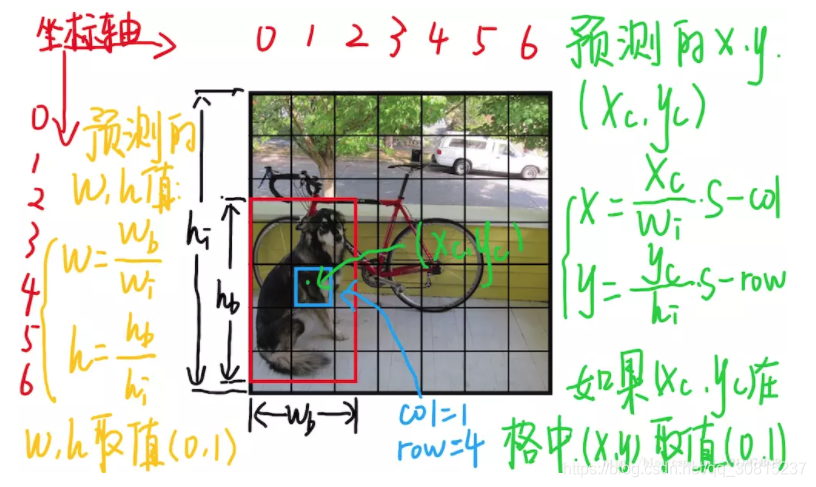  
③ 2个bounding box的置信度  
bounding box的置信度 = 该bounding box内存在对象的概率 * 该bounding box与该对象实际bounding box的IOU，公式:  
  
    Pr(Object)是bounding box内存在对象的概率，区别于 P(C_i|Object)。Pr(Object)并不管是哪个对象，它体现的是有或没有对象的概率。第①点中的P(C_i|Object)意思是假设已经有一个对象在网格中了，这个对象具体是哪一个。  
&nbsp;&nbsp;&nbsp;&nbsp; IOU<sub>pred</sub><sup>truth</sup>是 bounding box 与对象真实bounding box 的IOU。要注意的是，现在讨论的30维向量中的bounding box是YOLO网络的输出，也就是预测的bounding box。所以IOU<sub>pred</sub><sup>truth</sup> 体现了预测的bounding box与真实bounding box的接近程度。还要说明的是，虽然有时说"预测"的bounding box，但这个IOU是在训练阶段计算的。等到了测试阶段（Inference），这时并不知道真实对象在哪里，只能完全依赖于网络的输出，这时已经不需要（也无法）计算IOU了。  
&nbsp;&nbsp;&nbsp;&nbsp;综合来说，一个bounding box的置信度Confidence意味着它是否包含对象且位置准确的程度。置信度高表示这里存在一个对象且位置比较准确，置信度低表示可能没有对象 或者 即便有对象也存在较大的位置偏差。  
&nbsp;&nbsp;&nbsp;&nbsp;总的来说，30维向量 = 20个对象的概率 + 2个bounding box * 4个坐标 + 2个bounding box的置信度  
> 注意：class 信息是针对每个网格的，confidence 信息是针对每个 bounding box 的。  

### 网络定义
YOLO检测网络包括**24个卷积层和2个全连接层**，如下图所示。  
其中，**卷积层用来提取图像特征，全连接层用来预测图像位置和类别概率值**。  
YOLO网络借鉴了GoogLeNet分类网络结构。不同的是，YOLO未使用inception module，而是使用1x1卷积层（此处1x1卷积层的存在是为了跨通道信息整合）+3x3卷积层简单替代。  
YOLO论文中，作者还给出一个更轻快的检测网络fast YOLO，它只有9个卷积层和2个全连接层。使用titan x GPU，fast YOLO可以达到155fps的检测速度，但是mAP值也从YOLO的63.4%降到了52.7%，但却仍然远高于以往的实时物体检测方法（DPM）的mAP值。  

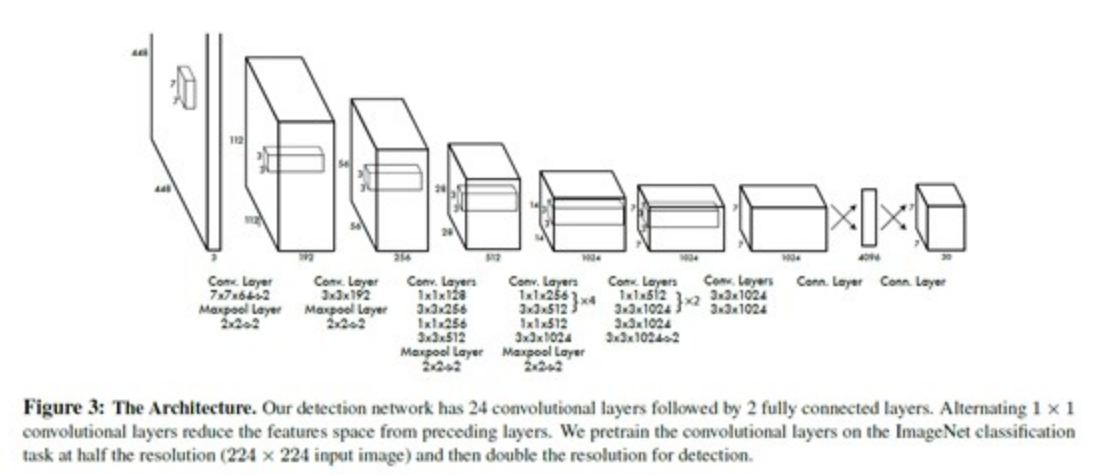

### representation定义
本部分给出YOLO全连接输出层的定义。  
+ YOLO将输入图像分成SxS个格子  
+ 每个格子负责检测‘落入’该格子的物体  
+ 若某个物体的中心位置的坐标落入到某个格子，那么这个格子就负责检测出这个物体  如下图所示，图中物体狗的中心点（红色原点）落入第5行、第2列的格子内，所以这个格子负责预测图像中的物体狗  
+ 每个格子输出B个bounding box（包含物体的矩形区域）信息，以及C个物体属于某种类别的概率信息  
+ Bounding box信息包含5个数据值，分别是x,y,w,h,和confidence。其中x,y是指当前格子预测得到的物体的bounding box的中心位置的坐标。w,h是bounding box的宽度和高度。
> 注意：实际训练过程中，w和h的值使用图像的宽度和高度进行归一化到[0,1]区间内；x，y是bounding box中心位置相对于当前格子位置的偏移值，并且被归一化到[0,1]。  
+ confidence反映当前bounding box是否包含物体以及物体位置的准确性，计算方式如下：  
confidence = P(object) * IOU  
> 其中，若bounding box包含物体，则P(object) = 1；否则P(object) = 0. 
> IOU(intersection over union)为预测bounding box与物体真实区域的交集面积（以像素为单位，用真实区域的像素面积归一化到[0,1]区间）。  

因此，YOLO网络最终的全连接层的输出维度是 S*S*(B*5 + C)。YOLO论文中，作者训练采用的输入图像分辨率是448x448，S=7，B=2；采用VOC 20类标注物体作为训练数据，C=20。因此输出向量为7*7*(20 + 2*5)=1470维。作者开源出的YOLO代码中，全连接层输出特征向量各维度对应内容如下：

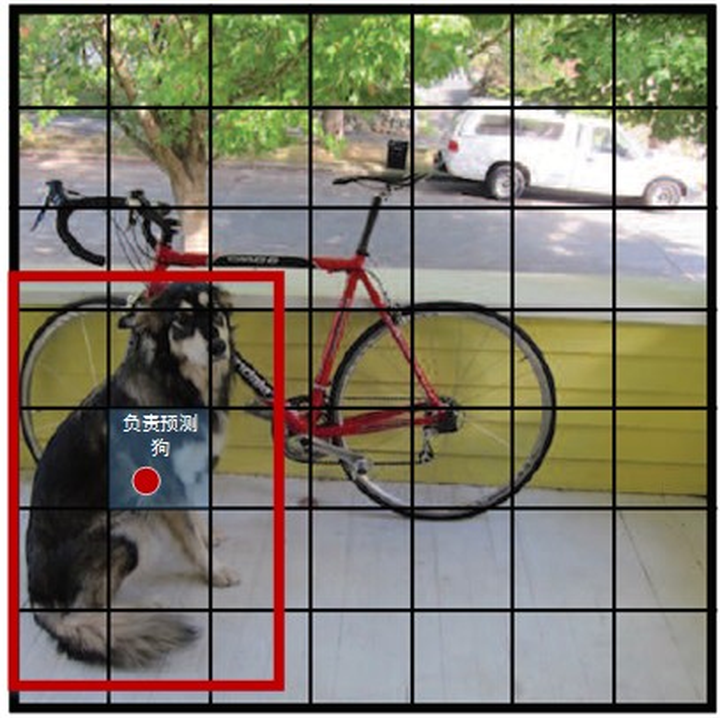  
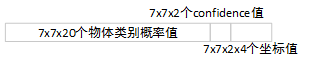  


> 注：  
> + 由于输出层为全连接层，因此在检测时，YOLO训练模型只支持与训练图像相同的输入分辨率。  
> + 虽然每个格子可以预测B个bounding box，但是最终只选择只选择IOU最高的bounding box作为物体检测输出，即每个格子最多只预测出一个物体。当物体占画面比例较小，如图像中包含畜群或鸟群时，每个格子包含多个物体，但却只能检测出其中一个。这是YOLO方法的一个缺陷。  


### Loss
YOLO使用**均方和误差**作为loss函数来优化模型参数，即网络输出的S*S*(B*5 + C)维向量与真实图像的对应S*S*(B*5 + C)维向量的均方和误差。如下式所示。其中，CoordErr、iouError和classError分别代表预测数据与标定数据之间的坐标误差、IOU误差和分类误差。
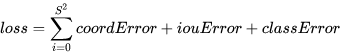  
**YOLO对上式loss的计算进行了如下修正:**  
**[1] 位置相关误差（坐标、IOU）与分类误差:** 对网络loss的贡献值是不同的，因此YOLO在计算loss时，使用 **$\lambda$<sub>coord</sub>=5** 修正coorError。
> 坐标误差：  
> + 只取正样本误差，即&para;<sub>ij</sub><sup>obj</sup>=1,意味着存在对象的网格才计入误差。  
> + 包含xy和wh两部分  
> + xy和wh误差系数相同，均为**$\lambda$<sub>coord</sub>=5**   
> + 正样本与负样本按照每个BBox计算  
> + wh计算要取根号  
> + 按照**BBox**计算
>> **对于物体尺寸问题：**  
>> 大物体误差对检测的影响应小于小物体误差对检测的影响。这是因为，相同的位置偏差占大物体的比例远小于同等偏差占小物体的比例。YOLO将物体大小的信息项（w和h）进行求平方根来改进这个问题。（注：这个方法并不能完全解决这个问题）。  
>>  对不同大小的bbox预测中，相比于大bbox预测偏一点，小box预测偏相同的尺寸对IOU的影响更大。而sum-square error loss中对同样的偏移loss是一样。 为了缓和这个问题，作者用了一个巧妙的办法，就是将box的width和height取平方根代替原本的height和width。 如下图：small bbox的横轴值较小，发生偏移时，反应到y轴上的loss（下图绿色）比big box(下图红色)要大。  
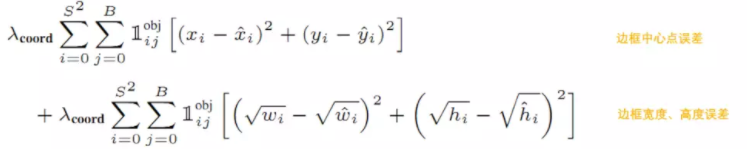  

**[2] IOU误差** 在计算IOU误差时，包含物体的格子与不包含物体的格子，二者的IOU误差对网络loss的贡献值是不同的。若采用相同的权值，那么不包含物体的格子的confidence值近似为0，变相放大了包含物体的格子的confidence误差在计算网络参数梯度时的影响。为解决这个问题，YOLO 使用**$\lambda$<sub>noobj</sub>=0.5** 修正iouError。（注此处的‘包含’是指存在一个物体，它的中心坐标落入到格子内）。   
> IOU误差：
> + 分为正样本(&para;<sub>ij</sub><sup>obj</sup>=1)误差和负样本&para;<sub>ij</sub><sup>obj</sup>=0误差  
> + 正样本和负样本误差系数不同，负样本误差系数为$\lambda$ <sub>noobj</sub>=0.5  
> + 按照**BBox**计算  

**[3]类别误差**   
> + 类别误差只包含正样本，即&para;<sub>i</sub><sup>obj</sup>=1  
> + 系数为1  
> + 按照**格子**进行计算  

综上，YOLO在训练过程中Loss计算如下式所示：  
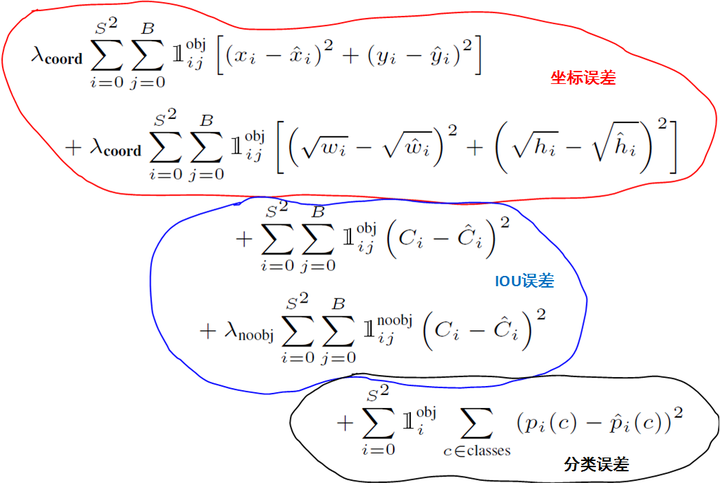  
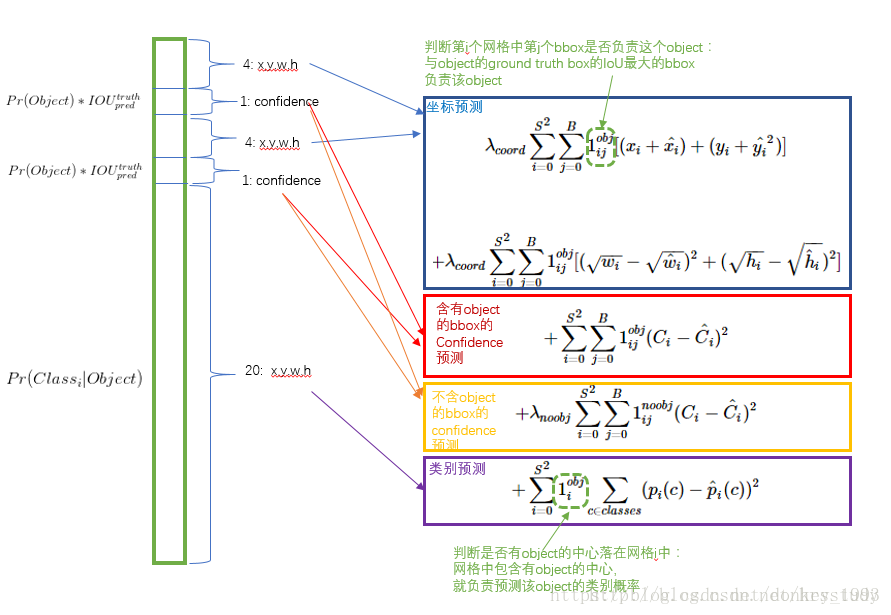  
其中，x,y,w,h,C,p为网络预测值，$\widehat{x}$,$\widehat{y}$,$\widehat{w}$,$\widehat{h}$,$\widehat{C}$,$\widehat{p}$为标注值。&para;<sub>i</sub><sup>obj</sup>表示物体落入格子i中，&para;<sub>ij</sub><sup>obj</sup>和&para;<sub>ij</sub><sup>noobj</sup>分别表示物体落入与未落入格子i的第j个bounding box内。  

> 注：  
> + YOLO方法模型训练依赖于物体识别标注数据，因此，对于非常规的物体形状或比例，YOLO的检测效果并不理想。  
> + YOLO采用了多个下采样层，网络学到的物体特征并不精细，因此也会影响检测效果。  
> + YOLO loss函数中，大物体IOU误差和小物体IOU误差对网络训练中loss贡献值接近（虽然采用求平方根方式，但没有根本解决问题）。因此，对于小物体，小的IOU误差也会对网络优化过程造成很大的影响，从而降低了物体检测的定位准确性。  



YOLO模型训练分为两步：  
1）预训练。使用ImageNet 1000类数据训练YOLO网络的前20个卷积层+1个average池化层+1个全连接层。训练图像分辨率resize到224x224。  
2）用步骤1）得到的前20个卷积层网络参数来初始化YOLO模型前20个卷积层的网络参数，然后用VOC 20类标注数据进行YOLO模型训练。为提高图像精度，在训练检测模型时，将输入图像分辨率resize到448x448。  
（训练过程中的参数设置，请参考原始论文）

## 效果
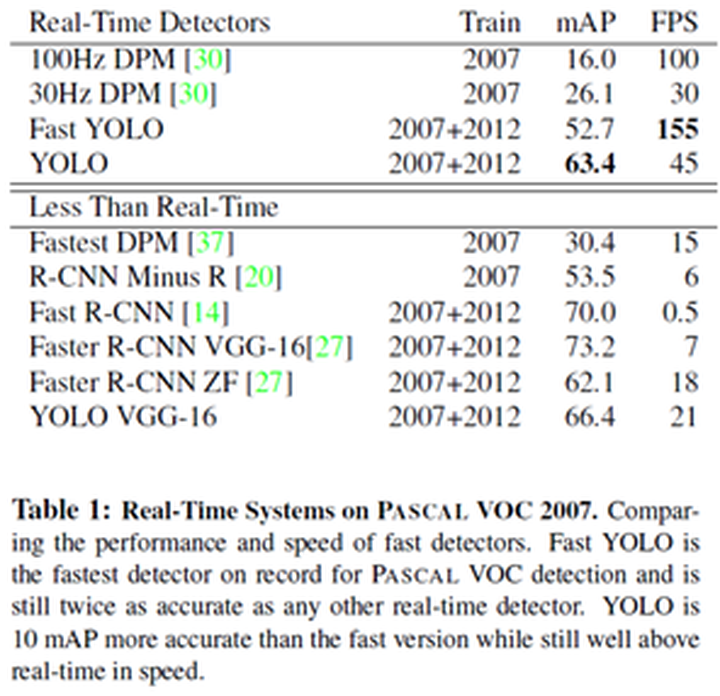

论文中，作者还给出了YOLO与Fast RCNN在各方面的识别误差比例，如下图。YOLO对背景内容的误判率（4.75%）比fast rcnn的误判率（13.6%）低很多。但是YOLO的定位准确率较差，占总误差比例的19.0%，而fast rcnn仅为8.6%。  
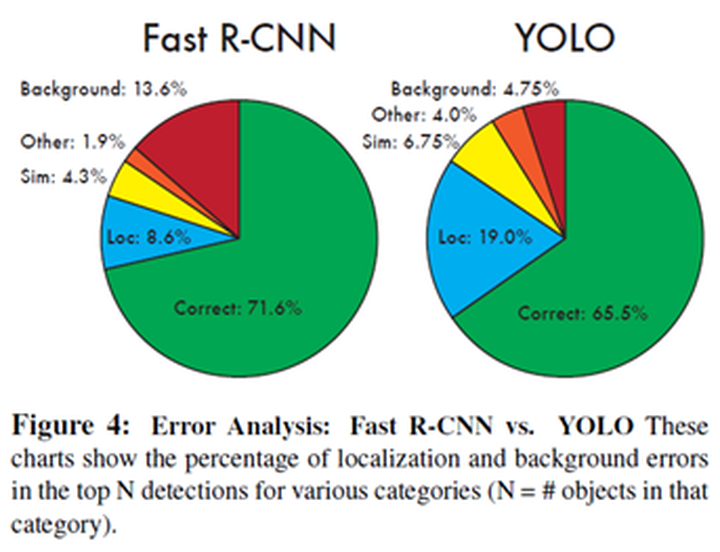

**YOLO非常快。**由于检测问题是一个回归问题，所以不需要复杂的管道。它比“R-CNN”快1000倍，比“Fast R-CNN”快100倍。它能够处理实时视频流，延迟小于25毫秒。它的精度是以前实时系统的两倍多。同样重要的是，YOLO遵循的是“端到端深度学习”的实践。

综上  
YOLO具有如下优点：  
+ 快。YOLO将物体检测作为回归问题进行求解，整个检测网络pipeline简单。在titan x GPU上，在保证检测准确率的前提下（63.4% mAP，VOC 2007 test set），可以达到45fps的检测速度。  
+ 背景误检率低。YOLO在训练和推理过程中能‘看到’整张图像的整体信息，而基于region proposal的物体检测方法（如rcnn/fast rcnn），在检测过程中，只‘看到’候选框内的局部图像信息。因此，若当图像背景（非物体）中的部分数据被包含在候选框中送入检测网络进行检测时，容易被误检测成物体。测试证明，YOLO对于背景图像的误检率低于fast rcnn误检率的一半。  
+ 通用性强。YOLO对于艺术类作品中的物体检测同样适用。它对非自然图像物体的检测率远远高于DPM和RCNN系列检测方法。  

但相比RCNN系列物体检测方法，YOLO具有以下缺点：  
+ 识别物体位置精准性差。
+ 召回率低。


## 改进
> 为提高物体定位精准性和召回率:  
+ YOLO作者提出了YOLO9000，提高训练图像的分辨率  
+ 引入了faster rcnn中anchor box的思想  
+ 对各网络结构及各层的设计进行了改进  
+ 输出层使用卷积层替代YOLO的全连接层  
+ 联合使用coco物体检测标注数据和imagenet物体分类标注数据训练物体检测模型。  
+ 相比YOLO，YOLO9000在识别种类、精度、速度、和定位准确性等方面都有大大提升。（yolo9000详解有空给出）

## 数据预处理
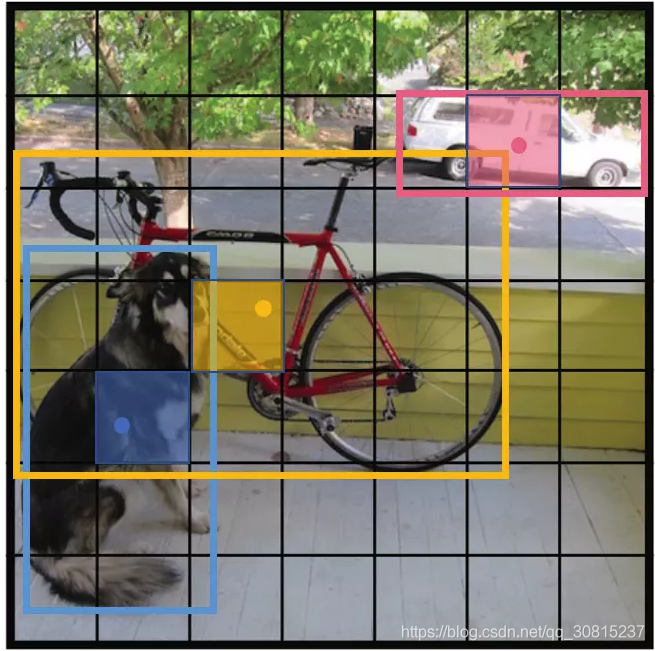  
作为监督学习，我们需要先构造好训练样本，才能让模型从中学习。对于一张输入图片，其对应输出的7*7*30张量（也就是监督学习所说的标签label）应该填写什么数据呢?首先，输出的 7*7维度对应于输入的 7*7 网格。然后具体看下30维向量的填写。  
① 20个对象分类的概率  
     对于输入图像中的每个对象，先找到其中心点。比如图中的自行车，其中心点在黄色圆点位置，中心点落在黄色网格内，所以这个黄色网格对应的30维向量中，自行车的概率是1，其它对象的概率是0。所有其它48个网格的30维向量中，该自行车的概率都是0。这就是所谓的"中心点所在的网格对预测该对象负责"。狗和汽车的分类概率也是同样的方法填写。  
② 2个bounding box的位置  
      训练样本的bounding box位置应该填写对象实际的bounding box，但一个对象对应了2个bounding box参数，应该把实际的bounding box填在哪一个里面？上面讨论过，需要根据网络输出的bounding box与对象实际bounding box的IOU来选择，所以要在训练过程中动态决定到底填哪一个bounding box。参考下面第③点。  
③ 2个bounding box的置信度  
上面讨论过置信度公式：    
  
   IOU<sub>pred</sub><sup>truth</sup>可以直接计算出来，就是用网络输出的2个bounding box与对象真实bounding box一起计算出IOU。然后看2个bounding box的IOU，哪个比较大（更接近实际的bounding box），就由哪个bounding box来负责预测该对象是否存在，即该bounding box的Pr(Object)=1，同时把对象真实的bounding box参数填入到这个bounding box位置向量处。另一个不负责预测的bounding box的Pr(Object)=0。 
    总的来说就是，与对象实际bounding box最接近的那个bounding box，其Confidence=IOU<sub>pred</sub><sup>truth</sup>，该网格的其它bounding box的Confidence=0。  
举个例子，比如上图中自行车的中心点位于4行3列网格中，所以输出tensor中4行3列位置的30维向量如下图所示。  
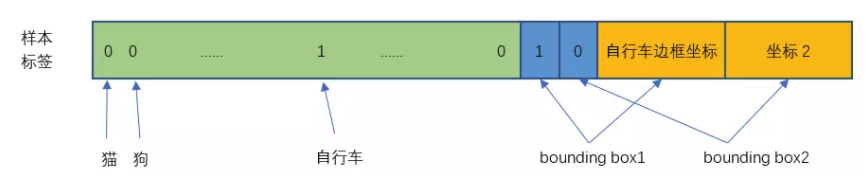  
&nbsp;&nbsp;&nbsp;&nbsp;4行3列网格位置有一辆自行车，它的中心点在这个网格内，把自行车的实际边框参数填入样本标签向量中的bounding box1位置。注意，图中将自行车实际边框参数放在bounding box1，但实际上是在训练过程中，等网络输出以后，比较两个bounding box1和bounding box2与自行车实际bounding box的IOU，发现输出的bounding box1与实际边框的IOU最大，所以把自行车的实际bounding box参数放置在图中bounding box1位置，且该bounding box1的置信度设为1，bounding box2正常存入，同时置信度置0.  

## 训练

## 验证
训练好的YOLO网络，输入一张图片，将输出一个 7*7*30 的张量（tensor）来表示图片中所有网格包含的对象（概率）以及该对象可能的2个位置（bounding box）和置信度。YOLO采用NMS（Non-maximal suppression，非极大值抑制）算法，从中提取出最有可能的那些对象和位置。  
NMS（非极大值抑制）:  
&nbsp;&nbsp;&nbsp;&nbsp;NMS其核心思想是：选择得分最高的作为输出，与该输出重叠的去掉，不断重复这一过程直到所有备选处理完。YOLO的NMS计算方法如下。  
&nbsp;&nbsp;&nbsp;&nbsp;网络输出的7*7*30的张量，在每一个网格中，对象C_i位于第j个bounding box的得分：
Score_{ij} = P(C_i|Object) * Confidence_j  
&nbsp;&nbsp;&nbsp;&nbsp;它代表着某个对象C_i存在于第j个bounding box的可能性。每个网格有：20个对象的概率x2个bounding box的置信度，共40个得分（候选对象）。49个网格共1960个得分。对每种对象分别进行NMS，那么每种对象有1960/20=98个得分。  
**NMS步骤如下：**  
1）设置一个Score的阈值，低于该阈值的候选对象排除掉（将该Score设为0）  
2）遍历每一个对象类别  
 2.1）遍历该对象的98个得分  
  2.1.1）找到Score最大的那个对象及其bounding box，添加到输出列表  
  2.1.2）对每个Score不为0的候选对象，计算其与上面2.1.1输出对象的bounding box的IOU  
  2.1.3）根据预先设置的IOU阈值，所有高于该阈值（重叠度较高）的候选对象排除掉（将Score设为0）  
  2.1.4）如果所有bounding box要么在输出列表中，要么Score=0，则该对象类别的NMS完成，返回步骤2处理下一种对象  
3）输出列表即为预测的对象    

总的来讲，yolo预测流程如下：  
1. 将图片resize到448*448大小。  
2.将图片放到网络里面进行处理。  
3.进行非极大值抑制处理得到结果。  

## 问题
① 一张图片最多可以检测出49个对象。每个30维向量中只有一组（20个）对象分类的概率，也就只能预测出一个对象。所以输出的 7*7=49个30维向量，最多表示出49个对象。  
② 总共有 49*2=98 个候选区（bounding box）,每个30维向量中有2组bounding box，所以总共是98个候选区。  
③ YOLO的bounding box并不是Faster RCNN的Anchor  
Faster RCNN等一些算法采用每个grid中手工设置n个Anchor（先验框，预先设置好位置的bounding box）的设计，每个Anchor有不同的大小和宽高比。YOLO的bounding box看起来很像一个grid中2个Anchor，但它们不是。YOLO并没有预先设置2个bounding box的大小和形状，也没有对每个bounding box分别输出一个对象的预测。它的意思仅仅是对一个对象预测出2个bounding box，选择预测得相对比较准的那个。
&nbsp;&nbsp;&nbsp;&nbsp;我们需要事先根据样本给出一个正确的bounding box作为回归的目标。YOLO的2个bounding box事先并不知道会在什么位置，只有经过前向计算，网络会输出2个bounding box，这两个bounding box与样本中对象实际的bounding box计算IOU。这时才能确定，IOU值大的那个bounding box，作为负责预测该对象的bounding box。  
&nbsp;&nbsp;&nbsp;&nbsp;训练开始阶段，网络预测的bounding box可能都是乱来的，但总是选择IOU相对好一些的那个，随着训练的进行，每个bounding box会逐渐擅长对某些情况的预测（可能是对象大小、宽高比、不同类型的对象等）。所以，这是一种进化或者非监督学习的思想。  
&nbsp;&nbsp;&nbsp;&nbsp;另外就是一个Object只由一个grid来进行预测，不要多个grid都抢着预测同一个Object。更具体一点说，就是在设置训练样本的时候，样本中的每个Object归属到且仅归属到一个grid，即便有时Object跨越了几个grid，也仅指定其中一个。具体就是计算出该Object的bounding box的中心位置，这个中心位置落在哪个grid，该grid对应的输出向量中该对象的类别概率是1（该gird负责预测该对象），所有其它grid对该Object的预测概率设为0（不负责预测该对象）。  
&nbsp;&nbsp;&nbsp;&nbsp;还有：虽然一个grid中会产生2个bounding box，但我们会选择其中一个作为预测结果，另一个会被忽略。下面构造训练样本的部分会看的更清楚。  
④ 可以调整网格数量、bounding box数量  
&nbsp;&nbsp;&nbsp;&nbsp;7*7网格，每个网格2个bounding box，对448*448输入图像来说覆盖粒度有点粗。我们也可以设置更多的网格以及更多的bounding box。设网格数量为 S*S，每个网格产生B个边框，网络支持识别C个不同的对象。这时，输出的向量长度为：C + B * (4+1)，整个输出的tensor就是：S * S * (C + B * (4+1))  
&nbsp;&nbsp;&nbsp;&nbsp;YOLO选择的参数是 7*7网格，2个bounding box，20种对象，因此输出向量长度 = 20 + 2 * (4+1) = 30。整个输出的tensor就是 7*7*30。因为网格和bounding box设置的比较稀疏，所以这个版本的YOLO训练出来后预测的准确率和召回率都不是很理想，后续的v2、v3版本还会改进。当然，因为其速度能够满足实时处理的要求，所以对工业界还是挺有吸引力的。  